In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models
import pandas as pd
import os
import cv2

## Part 1: Data Preprocessing

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 設定資料路徑                         變數的設置是為了讓程式在後續載入資料時能清楚知道各天氣類別的影像在哪裡
# training data path
trcloudy='/content/drive/MyDrive/weather_image/train/cloudy/'
trrain='/content/drive/MyDrive/weather_image/train/rain/'
trshine='/content/drive/MyDrive/weather_image/train/shine/'
trsunrise='/content/drive/MyDrive/weather_image/train/sunrise/'
# testing data path
testpath='/content/drive/MyDrive/weather_image/test/'      #用來繳交上傳檔案

In [4]:
# 顯示資料筆數  os.listdir(path):這個函數來自 Python 的 os 模組，它會列出指定路徑下的所有檔案和資料夾名稱，並以清單（list）形式回傳。
# 由此可知，每一類別有幾筆的資料
#---------------------to-do--------------------------------------------#

# 顯示資料筆數
def count_files_in_directory(path):
    return len(os.listdir(path))

# 列出每個訓練類別的資料筆數
print(f'train cloudy length: {count_files_in_directory(trcloudy)}')
print(f'train rain length: {count_files_in_directory(trrain)}')
print(f'train shine length: {count_files_in_directory(trshine)}')
print(f'train sunrise length: {count_files_in_directory(trsunrise)}')

# 列出測試資料的資料筆數
print(f'test data length: {count_files_in_directory(testpath)}')


#---------------------to-do--------------------------------------------#

train cloudy length: 280
train rain length: 199
train shine length: 232
train sunrise length: 337
test data length: 75


### convert image data to numpy

In [5]:
# convert the train data to numpy
from PIL import Image  # 確保正確匯入 Image 模組
#---------------------to-do--------------------------------------------#

# 儲存影像資料和對應的標籤
tr_data = []
tr_label = []

# 處理影像的函數
def process_images(path, label, data_list, label_list):
    for filename in os.listdir(path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 根據實際情況調整影像副檔名
            img_path = os.path.join(path, filename)
            img = Image.open(img_path)

            if img.mode != 'RGB':
                img = img.convert('RGB')  # 將灰度影像轉換為 RGB

            img = img.resize((300, 300))  # 調整影像大小
            data_list.append(np.array(img))  # 將影像資料存放到資料清單中
            label_list.append(label)  # 將標籤存放到標籤清單中

# 處理四個資料夾中的影像
process_images(trcloudy, 'cloudy', tr_data, tr_label)
process_images(trrain, 'rain', tr_data, tr_label)
process_images(trshine, 'shine', tr_data, tr_label)
process_images(trsunrise, 'sunrise', tr_data, tr_label)



In [6]:
# convert the test data to numpy
te_filename=[]
te_data=np.empty(shape=(75,300,300,3))
#---------------------to-do--------------------------------------------#
def process_test_images(path, filename_list, data_array, index):
    for filename in os.listdir(path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 根據實際情況調整影像副檔名
            img_path = os.path.join(path, filename)
            img = Image.open(img_path)

            if img.mode != 'RGB':
                img = img.convert('RGB')  # 將灰度影像轉換為 RGB

            img = img.resize((300, 300))  # 調整影像大小
            data_array[index] = np.array(img)  # 將影像資料存放到 NumPy 陣列中
            filename_list.append(filename)  # 將影像檔名存放到檔名清單中
            index += 1
    return index
y=0
y = process_test_images(testpath, te_filename, te_data, y)
print(f'Total test images processed: {y}')
print(f'Test data shape: {te_data.shape}')



#---------------------to-do--------------------------------------------#

Total test images processed: 75
Test data shape: (75, 300, 300, 3)


In [7]:
# show data size
#---------------------to-do--------------------------------------------#
print(f'train data size:{len(tr_data)}')
print(f'train label size:{len(tr_label)}')
print(f'test data size:{te_data.shape}')


#總共有1048張圖片 300*300 RGB 75張測試資料


#---------------------to-do--------------------------------------------#

train data size:1045
train label size:1045
test data size:(75, 300, 300, 3)


### shuffle

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# 將資料和標籤轉換為 NumPy 陣列
tr_data = np.array(tr_data)
tr_label = np.array(tr_label).reshape(-1, 1)

# 使用 one-hot 編碼
encoder = OneHotEncoder(sparse_output=False)
tr_label_encoded = encoder.fit_transform(tr_label)

# 打亂資料順序，保持資料和標籤的對應關係
tr_data, tr_label_encoded = shuffle(tr_data, tr_label_encoded, random_state=42)
print(tr_label_encoded)

print(f'Shuffled train data shape: {tr_data.shape}')
print(f'Shuffled train label shape: {tr_label_encoded.shape}')


[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Shuffled train data shape: (1045, 300, 300, 3)
Shuffled train label shape: (1045, 4)


"\n# 使用 one-hot 編碼\nencoder = OneHotEncoder()\ntr_label_encoded = encoder.fit_transform(tr_label.reshape(-1, 1))\nprint(tr_label_encoded)\n\n# 打亂資料順序\ntr_data, tr_label_encoded = shuffle(tr_data, tr_label_encoded, random_state=42)\n\n# 顯示資料形狀以確認\nprint(f'Shuffled train data shape: {tr_data.shape}')\nprint(f'Shuffled train label shape: {tr_label_encoded.shape}')\n"

### train_validation data split 從訓練資料中拿出一部分來驗證

In [9]:
from sklearn.model_selection import train_test_split
# train_validation data split
#val_data數量固定262個
#---------------------to-do--------------------------------------------#
print('train data size: ',tr_data.shape)
tr_data, val_data, tr_label_encoded, val_label_encoded = train_test_split(
    tr_data, tr_label_encoded, test_size=0.25, random_state=42)




#---------------------to-do--------------------------------------------#
print('train data size: ',tr_data.shape)
print('validation data size: ',val_data.shape)
print('train label size: ',tr_label_encoded.shape)
print('validation label size: ',val_label_encoded.shape)

train data size:  (1045, 300, 300, 3)
train data size:  (783, 300, 300, 3)
validation data size:  (262, 300, 300, 3)
train label size:  (783, 4)
validation label size:  (262, 4)


## Part 2: Build a simple CNN

In [10]:
# define model
cnn=models.Sequential() # name the network 初始化
#---------------------to-do--------------------------------------------#
#層的定義不能與顯示相同，需要自己建立自己的
# feature extraction 利用cnn.add 加入convolution layer padding MaxPooling


cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)))
cnn.add(layers.MaxPooling2D((2, 2), padding='same'))


cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2), padding='same'))


cnn.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(layers.MaxPooling2D((2, 2), padding='same'))


# neron network 全連接層
cnn.add(layers.Flatten())


cnn.add(layers.Dense(256, activation='relu'))

cnn.add(layers.Dense(128, activation='relu'))

cnn.add(layers.Dense(4, activation='softmax'))


# show the model structure




#---------------------to-do--------------------------------------------#
cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 300, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 184832)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      47,317,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,443,908 (180.98 MB)

 Trainable params: 47,443,908 (180.98 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# comiple model
from tensorflow.keras.optimizers import Adam
#---------------------to-do--------------------------------------------#

learning_rate = 0.0001


optimizer = Adam(learning_rate=learning_rate)


cnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])



#---------------------to-do--------------------------------------------#

In [12]:
#history
#---------------------to-do--------------------------------------------#
history=cnn.fit(tr_data, tr_label_encoded, epochs=30, batch_size=32, validation_split=0.25)



#---------------------to-do--------------------------------------------#

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 730ms/step - accuracy: 0.3707 - loss: 82.0327 - val_accuracy: 0.6276 - val_loss: 8.3023
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.7000 - loss: 5.0555 - val_accuracy: 0.7449 - val_loss: 3.4555
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8188 - loss: 1.9378 - val_accuracy: 0.8214 - val_loss: 1.2877
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9235 - loss: 0.5258 - val_accuracy: 0.8469 - val_loss: 0.9899
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9530 - loss: 0.2121 - val_accuracy: 0.8724 - val_loss: 0.7733
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9826 - loss: 0.0575 - val_accuracy: 0.8571 - val_loss: 0.7079
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9887 - loss: 0.0260 - val_accuracy: 0.8724 - val_loss: 0.7029
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9545 - loss: 0.1917 - val_accuracy: 0.841

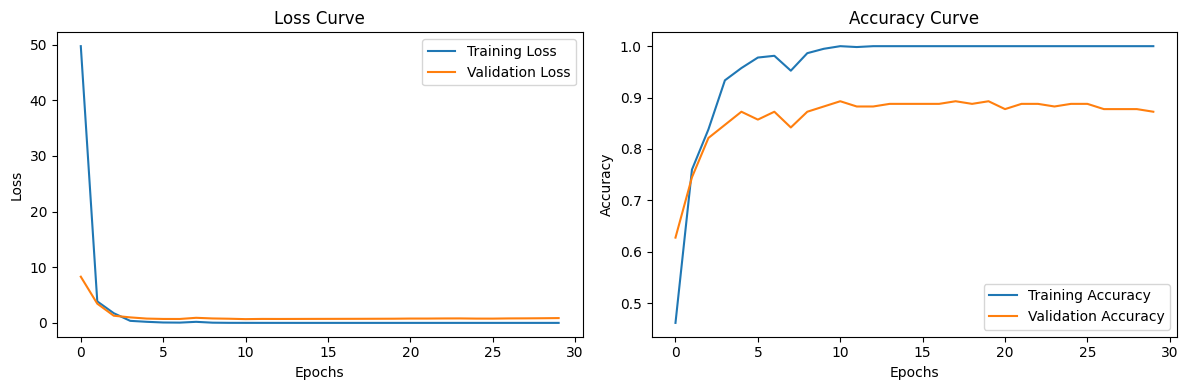

In [13]:
# 印出 loss curve   和  accuracy curve
#---------------------to-do--------------------------------------------#
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()







#---------------------to-do--------------------------------------------#


### Plot the confusion matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step


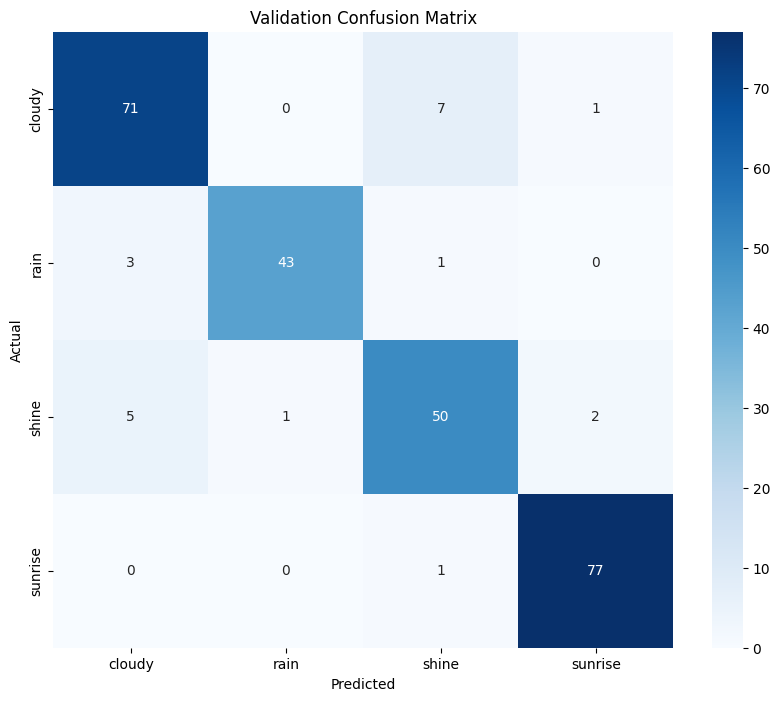

In [14]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
#---------------------to-do--------------------------------------------#
# 使用模型對驗證數據進行預測
val_predictions = cnn.predict(val_data)

# 獲取預測的類別
val_predictions_classes = np.argmax(val_predictions, axis=1)

# 獲取實際類別
val_true_classes = np.argmax(val_label_encoded, axis=1)

# 計算混淆矩陣
val_conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

# 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sn.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()








#---------------------to-do--------------------------------------------#

# Output the csv file

In [15]:
import pandas as pd

In [16]:
#印出預測值
#---------------------to-do--------------------------------------------#
test_prediction = cnn.predict(te_data)

test_predictions_classes = np.argmax(test_prediction, axis=1)
print(test_predictions_classes)






#---------------------to-do--------------------------------------------#

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 596ms/step
[0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 3 1 1 1 2 0 1 1 0 0 2 0 2 0 1 1 1 0 2 1
 1 1 1 3 3 3 3 3 3 3 3 0 2 3 3 3 2 0 2 3 2 3 3 3 3 3 3 2 2 3 2 2 3 0 0 0 0
 3]


In [17]:
# 創建 DataFrame
test_label = pd.DataFrame()
test_label['image_id'] = te_filename
test_label['labels'] = test_predictions_classes

# 定義一個排序函式來提取數字並進行數字排序
test_label['numeric_id'] = test_label['image_id'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

# 根據 'numeric_id' 排序（這樣會按數字順序）
test_label = test_label.sort_values(by='numeric_id')

# 不再需要 'numeric_id' 欄位，將其刪除
test_label = test_label.drop(columns=['numeric_id'])

# 儲存結果為 CSV 檔案
test_label.to_csv('/content/drive/MyDrive/weather_image/predict_label.csv', index=False)

# Part3: Data augmentation

In [38]:
#定義data_augmentation 利用tf.keras.Sequential 去做隨機翻轉
#---------------------to-do--------------------------------------------#

# 定義數據增強

data_augmentation = tf.keras.Sequential([
    # 隨機水平翻轉
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical")


])




#---------------------to-do--------------------------------------------#

Text(0.5, 1.0, 'data augmentation')

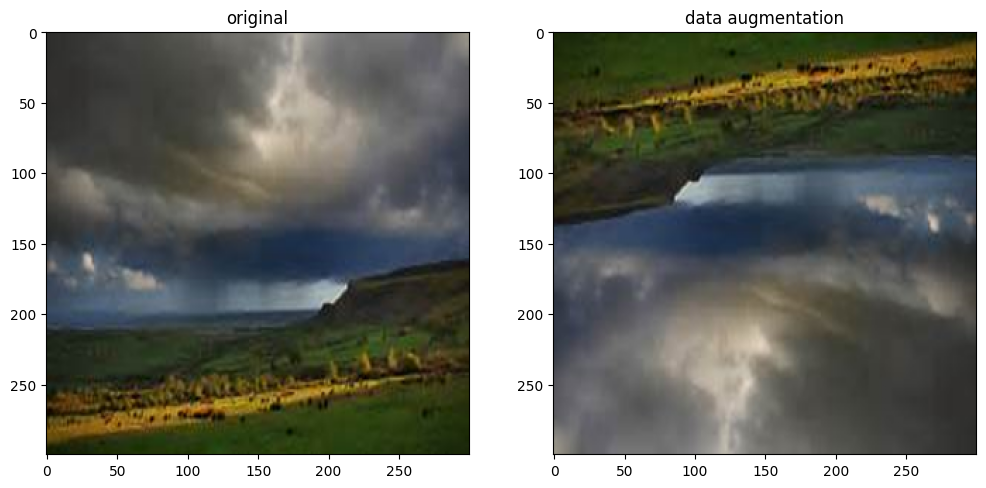

In [39]:
#任意在訓練資料中找一張圖片，並印出增強後的照片
#---------------------to-do--------------------------------------------#

image = tr_data[0]

# 將圖像轉換為float32並標準化到[0, 1]範圍
image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0

# 使用增強層來增強圖像
augmented_image = data_augmentation(image)

# 確保像素值在 [0, 1] 範圍內
augmented_image = tf.clip_by_value(augmented_image, 0.0, 1.0)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(tr_data[0])
axes[0].set_title("original")

axes[1].imshow(augmented_image.numpy())
axes[1].set_title("data augmentation")






#---------------------to-do--------------------------------------------#